# Introduction

This dataset was sourced from Kaggle and includes YouTube trending data for various countries. In this project, I'll be analyzing data from specifically Great Britain and determining the answer to the following questions From the data.

1. What is the average length of a trending video?
2. Can a video's number of likes be predicted from the number of views and number of comments using Multiple Linear Regression?
3. Which tags appear most frequently?
4. What are the most common topics featured in the videos' description?
5. According to this dataset, which channel has the most trending videos?
6. In which month of the year are videos most likely to trend?

As usual, this data will need to be thoroughly cleaned and processed before any modelling or statistical analysis. 
I'll use NLP and multiple Linear Regression models to answer a few of the questions above. 

In [327]:
import pandas as pd

# Import the data

In [328]:
gb = pd.read_csv('GBvideos.csv')

In [329]:
gb.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...


In [330]:
gb.dtypes

video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
dtype: object

# Clean the data 

In [331]:
#Convert the publish time and trending date to datetime
gb.publish_time = pd.to_datetime(gb.publish_time)
gb.trending_date = pd.to_datetime(gb['trending_date'], format='%y.%d.%m')

In [332]:
gb.isna().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               612
dtype: int64

In [333]:
features_to_remove = ['thumbnail_link', 'comments_disabled', 'video_id']
gb.drop(labels=features_to_remove, inplace=True, axis=1)

# Exploratory Data Analysis 

In [334]:
# import libraries for visualisation 
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np 

In [335]:
pd.options.display.float_format = "{:.2f}".format
gb.describe()

,category_id,views,likes,dislikes,comment_count
count,38916.00,38916.00,38916.00,38916.00,38916.00
mean,16.83,5911943.63,134519.55,7612.56,13088.35
std,7.75,19001209.95,349989.31,50956.83,50667.40
min,1.00,851.00,0.00,0.00,0.00
25%,10.00,251527.25,5897.00,200.00,679.00
50%,20.00,981889.00,25182.50,821.00,2478.00
75%,24.00,3683628.50,114089.25,3357.50,9241.50
max,43.00,424538912.00,5613827.00,1944971.00,1626501.00


A quick overview of the data tells us that the mean number of likes is 5,911,943.63 and that 75% of the videos have less than 3,683,628.50 views. Clearly, the data has a very high standard deviation and so will need to be filtered to make model more accurate. At the moment, the dataset has 38916 observations. I will address this later in my analysis. Now, using the corr method on the DataFrame, I'll see which features correlate most with the dependent variable, views. Views will be my target variable since I'll be trying to predict the number of views of a video later. 

In [336]:
gb.corr()

,category_id,views,likes,dislikes,comment_count,ratings_disabled,video_error_or_removed
category_id,1.00,-0.17,-0.18,-0.02,-0.06,-0.06,-0.01
views,-0.17,1.00,0.80,0.39,0.47,0.01,0.01
likes,-0.18,0.80,1.00,0.45,0.74,-0.03,0.01
dislikes,-0.02,0.39,0.45,1.00,0.77,-0.01,0.01
comment_count,-0.06,0.47,0.74,0.77,1.00,-0.02,0.00
ratings_disabled,-0.06,0.01,-0.03,-0.01,-0.02,1.00,-0.00
video_error_or_removed,-0.01,0.01,0.01,0.01,0.00,-0.00,1.00


The variable with the highest correlation to views is likes. This makes sense given that a video would likely have more likes given the more views it receives.  It's worth mentioning that dislikes and likes have no significant correlation. This makes a lot of sense given YouTube videos are either largely popular or predominantly, unpopular. I'll now use a heatmap to better illustrate the correlations of variables

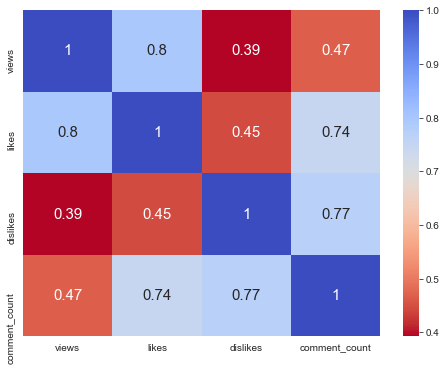

In [345]:
fig, ax = plt.subplots(figsize=(8,6))
heat_map_variables = gb[['views', 'likes', 'dislikes', 'comment_count']]
sns.heatmap(heat_map_variables.corr(),annot=True,cmap='coolwarm_r', annot_kws={'size': 15});

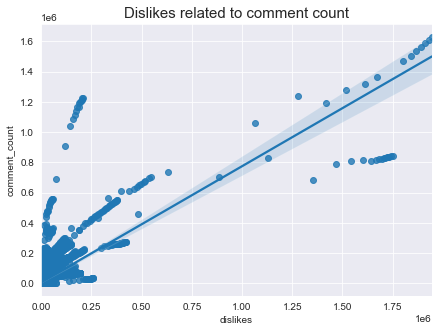

In [338]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.set_style('darkgrid')
plt.xlabel('Dislikes')
plt.ylabel('Comment_count')
plt.title('Dislikes related to comment count', size=15)
sns.regplot(x = 'dislikes', y = 'comment_count', data=gb);

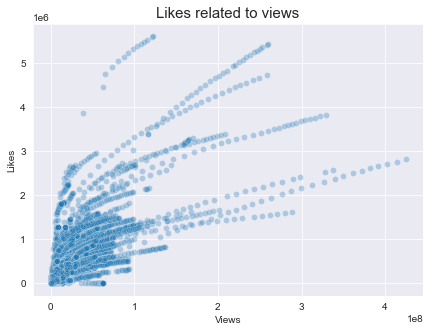

In [346]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.set_style('darkgrid')
plt.xlabel('Views')
plt.ylabel('Likes')
plt.title('Likes related to views', size=15)
sns.scatterplot(x = 'views', y = 'likes', data=gb, alpha=.3);

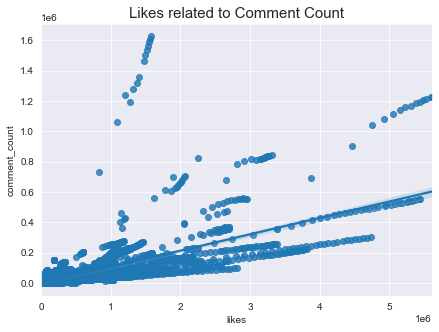

In [340]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.set_style('darkgrid')
plt.xlabel('Likes')
plt.ylabel('Comment Count')
plt.title('Likes related to Comment Count', size=15)
sns.regplot(x = 'likes', y = 'comment_count', data=gb);

As shown above, the relationship between likes and comment count is somewhat linear. However, there are some videos that have few views though receive disproportionately a lot of comments.  

# Data Selection
The independent variables chosen to predict likes are views and number of comments. Both have a relatively high correlation and so should lead to an accurate model. But we will see! Their correlation scores with likes are 0.8 and 0.74, respectively.

In [349]:
features = gb[['views', 'comment_count']]
likes = gb['likes']

In [356]:
# Split the data into train and test sections, with an 80-20 split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, likes, test_size = 0.2, random_state = 1)

7784

In [362]:
from sklearn.linear_model import LinearRegression

# instigate the model object 
model = LinearRegression()

# train the model on the training data 
model.fit(X_train, y_train)

LinearRegression()

# Evaluating the model 
The first method I'll use to evaluate the model is the score method, which produces an R^2 for the model. It's worth mentioning that the R^2 score evaluates how well model fits the observed data. In this case, the training data. The score suggests that roughly 80 percent of the data fits the regression model. Whilst not an absolute determiner of how good the model is, it is a promising score. Of the features, it would appear the views is the most predictive, followed by comment_count. 

In [363]:
model.score(X_train, y_train)

0.8087096442296271

In [364]:
model.score(X_test, y_test)

0.8198464829043315

In [369]:
sorted(list(zip(['views','comment_count'],model.coef_)),key = lambda x: abs(x[1]),reverse=True)

[('comment_count', 3.3174626968219685), ('views', 0.010489033862125512)]

Now, moving onto predicting the number of likes for the test data, where I can then compare them to the actual values for the test data. The perfect model would have homoscedasticity, where x = y.

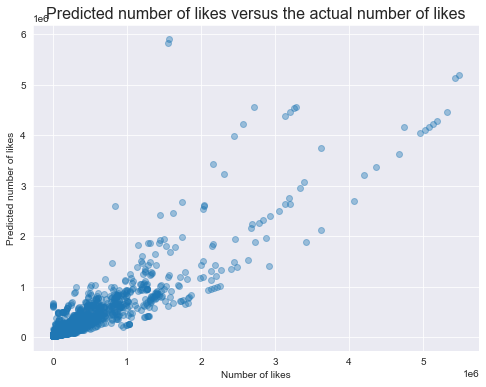

In [380]:
fig, ax = plt.subplots(figsize=(8, 6))
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.4)
plt.title('Predicted number of likes versus the actual number of likes', size=16)
plt.xlabel('Number of likes')
plt.ylabel('Predicted number of likes');

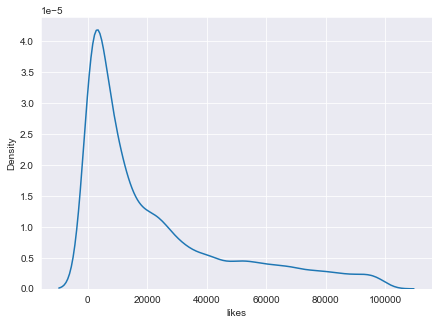

In [341]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.kdeplot(x = 'likes', data=gb[gb['likes'] < 100000]);

From the Kernal distribution estimation plot it's clear that most of the videos have less than 20,000 likes. 

### Which time of the day is most popular for publishing videos?

### Which tags appear most frequently?

### What are the most common topics featured in the videos' description?

### According to this dataset, which channel has the most trending videos?



### In which month of the year are videos most likely to trend?